# E-tivity 3 : Gerard O'Rourke, Student number : 24514772
This
workbook is
for E - tivity3.It follows the following structure
1.
The
workbook
environment is setup
1.
The
next
section
has
some
EDA
related
to
this
E - tivity
1.
Each
task
for this E - tivity then follows

Setup

In [407]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import manifold #needed for multidimensional scaling (MDS) and t-SNE
from sklearn import cluster #needed for k-Means clustering
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,MinMaxScaler, StandardScaler, RobustScaler, FunctionTransformer #needed for data preparation

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans,DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import set_config
from kneed import KneeLocator
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, auc, precision_recall_fscore_support, roc_curve


print(sklearn.__version__)

# needed for changing Ordinal values - see education
pd.set_option("future.no_silent_downcasting", True)
#sklearn.set_config(enable_metadata_routing=True)
set_config(transform_output='pandas')


1.6.1


#### Setup Environment
Load the data and keep a copy

In [408]:
# Load the dataset
df = pd.read_csv("./insurance.csv")

# keep a copy
df_original = df

print('(number of examples, number of attributes): ', df.shape)

(number of examples, number of attributes):  (1338, 7)


EDA

In [409]:
df.head()

,age,gender,bmi,children,smoker,region,insurance_cost
0,18,male,33.770,1,no,southeast,1725.55230
1,18,male,34.100,0,no,southeast,1137.01100
2,18,female,26.315,0,no,northeast,2198.18985
3,18,female,38.665,2,no,northeast,3393.35635
4,18,female,35.625,0,no,northeast,2211.13075


In [410]:
df.tail()

,age,gender,bmi,children,smoker,region,insurance_cost
1333,64,female,31.825,2,no,northeast,16069.08475
1334,64,female,26.885,0,yes,northwest,29330.98315
1335,64,male,26.410,0,no,northeast,14394.55790
1336,64,male,36.960,2,yes,southeast,49577.66240
1337,64,male,23.760,0,yes,southeast,26926.51440


In [411]:
df.describe()

,age,bmi,children,insurance_cost
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [412]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

In [413]:
numerical_attribute = ['age','bmi','children']

categorical_attribute=['gender','smoker','region']

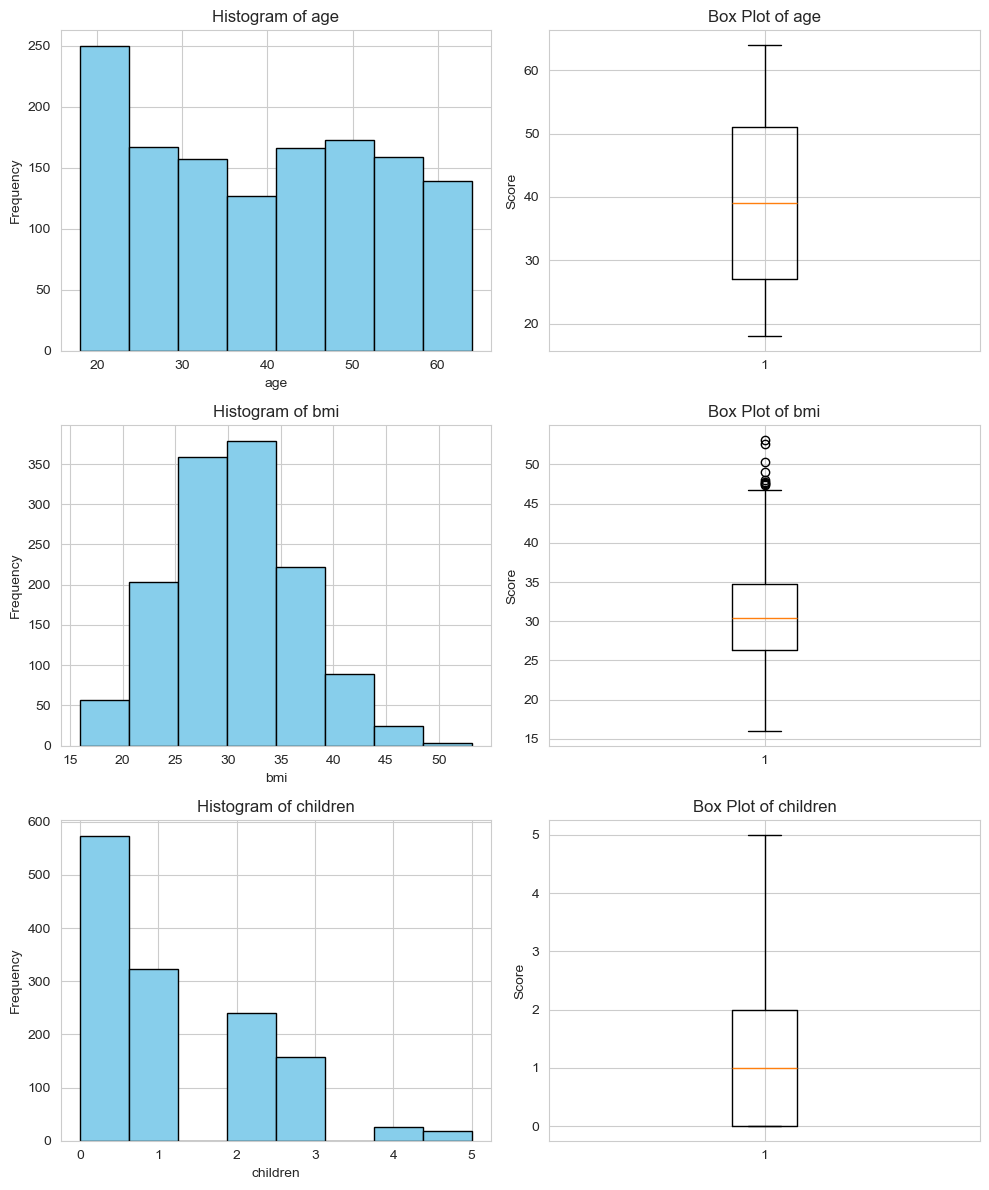

In [414]:
# df.boxplot(column=numerical_attribute)
# Set up the figure with two subplots side by side
fig, axes = plt.subplots(nrows=len(numerical_attribute), ncols=2, figsize=(10, 4 * len(numerical_attribute)))

for row, attribute in enumerate(numerical_attribute):


    # Histogram
    axes[row, 0].hist(df[attribute], bins=8, color='skyblue', edgecolor='black')
    axes[row, 0].set_title(f'Histogram of {attribute}')
    axes[row, 0].set_xlabel(attribute)
    axes[row, 0].set_ylabel('Frequency')

    # Box plot
    axes[row, 1].boxplot(df[attribute], vert=True)
    axes[row, 1].set_title(f'Box Plot of {attribute}')
    axes[row, 1].set_ylabel('Score')

# Display
plt.tight_layout()
plt.show()


In [415]:
df['gender'].value_counts()

gender
male      676
female    662
Name: count, dtype: int64

In [416]:
df['smoker'].value_counts()

smoker
no     1064
yes     274
Name: count, dtype: int64

In [417]:
df['region'].value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

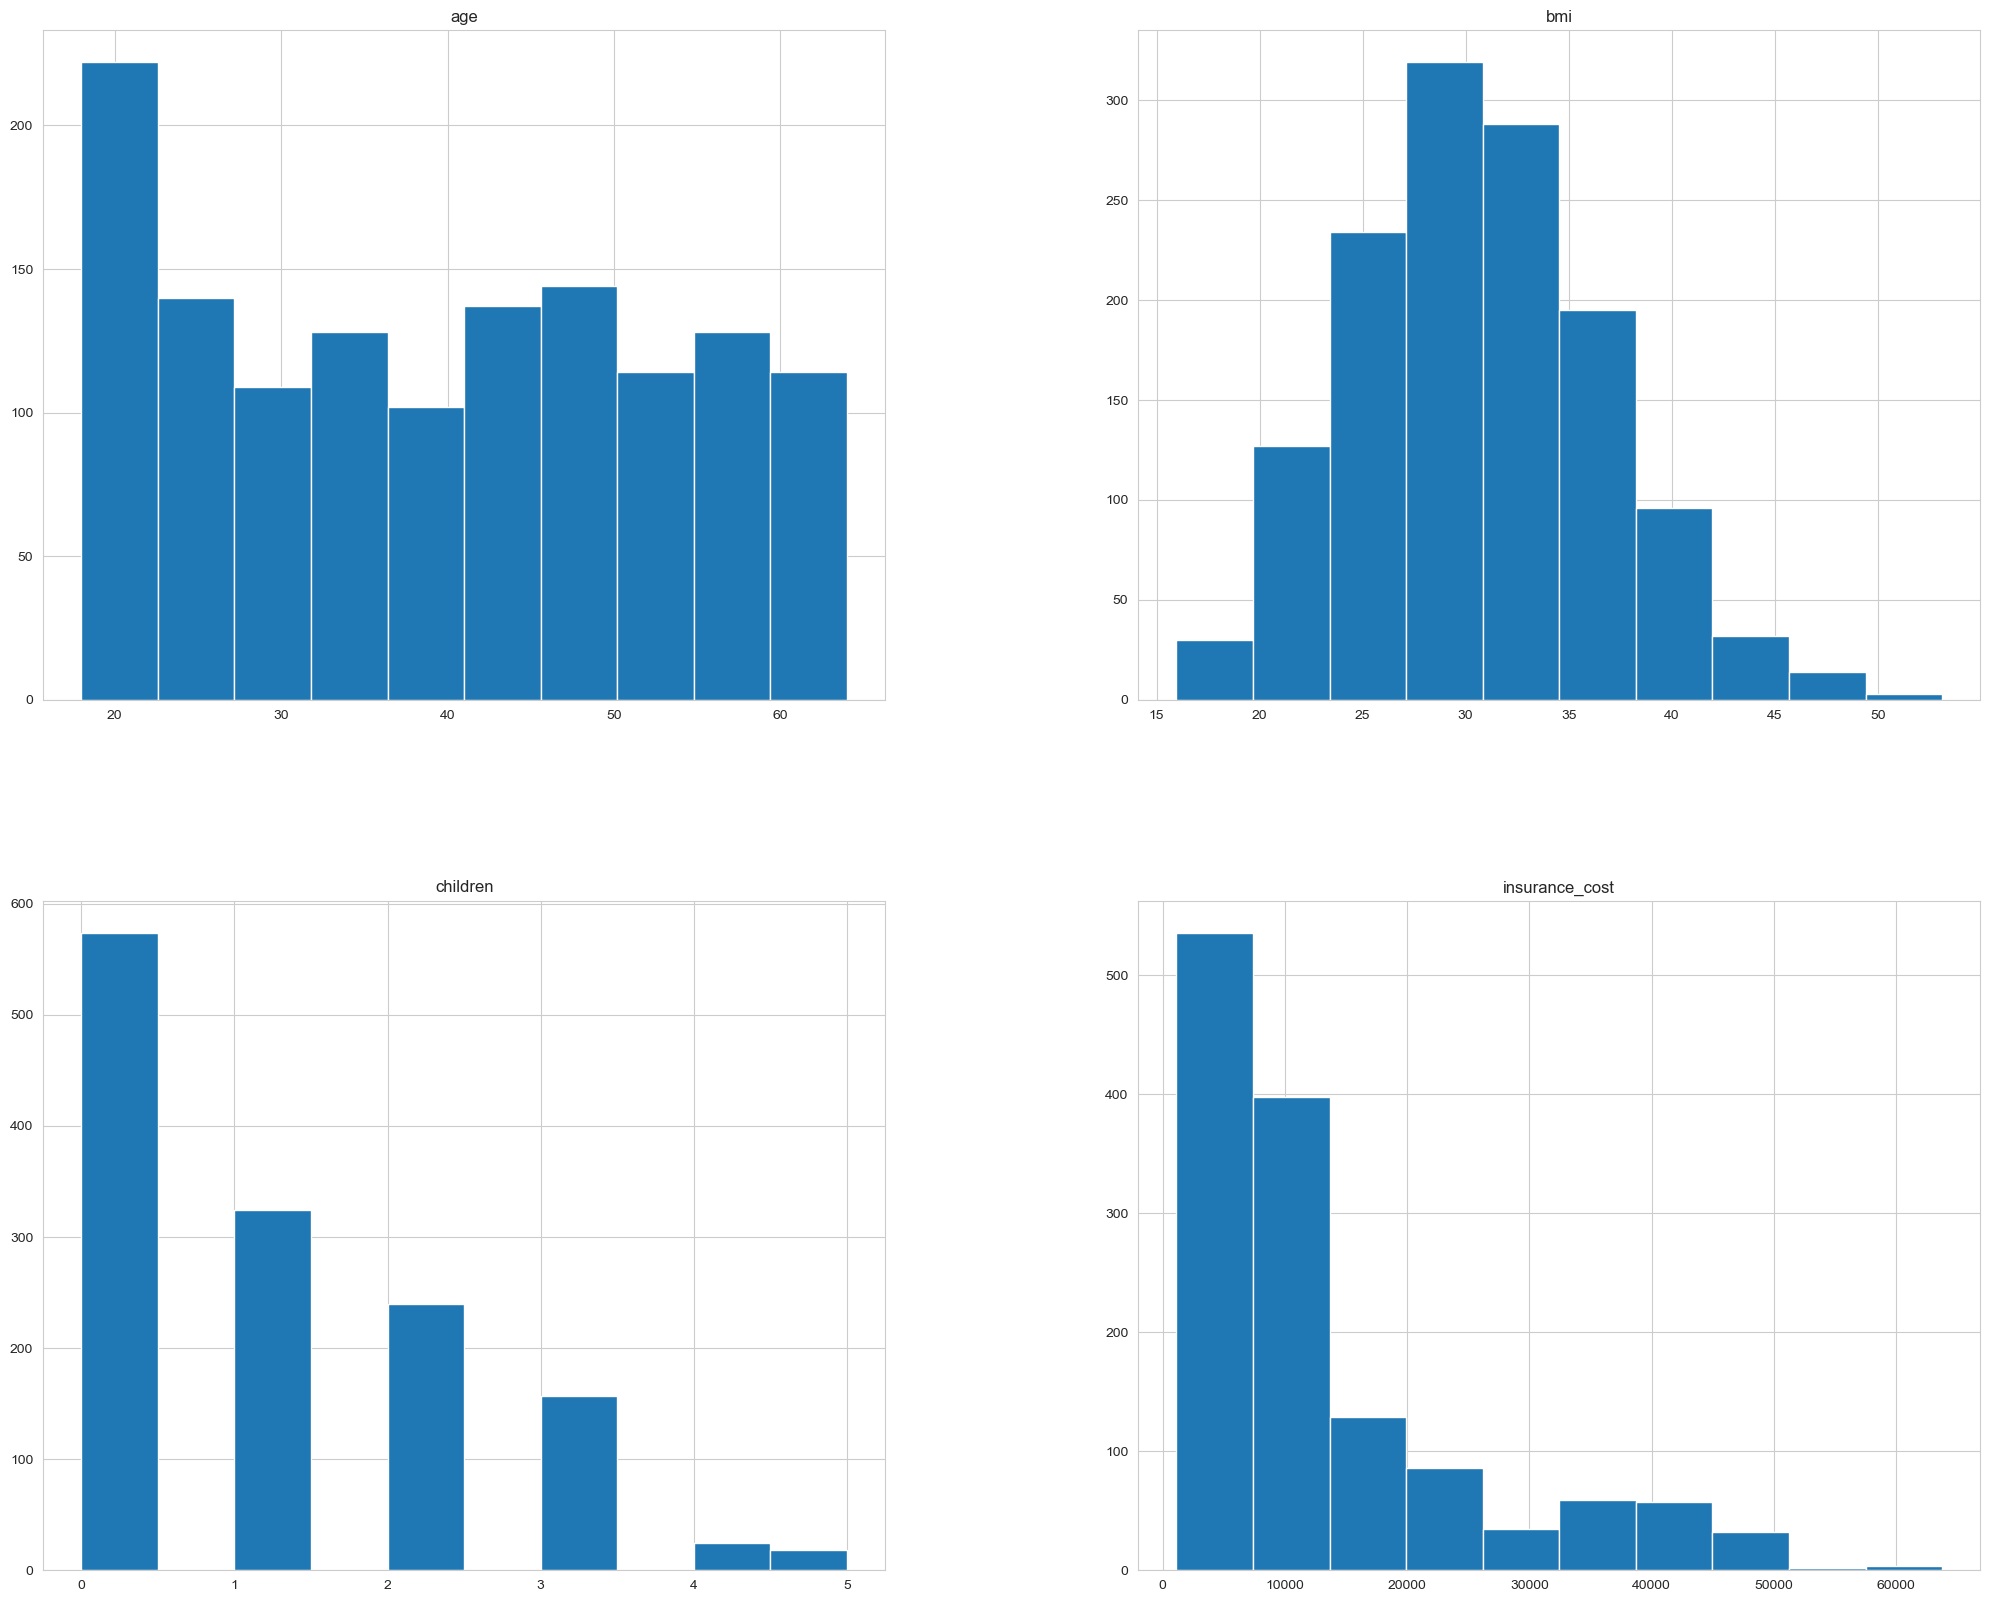

In [418]:
df.select_dtypes(include='number').hist(bins=10, figsize=(25, 20))
plt.show()

|Type| Attribute | Has Zeros | Outliers | Skewed | Map Values | Imput | Scale| One Hot Encode |Comment|
|-----|-----------|----------|----------|--------|------------|-------|------|----------------|----|
|| Age       | No| No |        | No         |            |       | |                | ||
|| Bmi       | No| Yes |        | No         |            |       | |                | ||
|| Children  | Yes|No| Right  | No         |            |       | |                | ||
|| Gender    | No ||        | Yes        |            |       |       |       |                | ||
|| Region    | No   | |        | Yes               |            |       |       |       |                | ||
|| Smoker    | No    ||        | Yes    |            |            |       | |                | ||

Pipeline

In [419]:
def map_gender(X):
    X = X.copy()
    X['gender'] = X['gender'].map({'male': 0, 'female': 1})
    return X

def map_smoker(X):
    X = X.copy()
    X['smoker'] = X['smoker'].map({'no': 0, 'yes': 1})
    return X


smoker_mapper = FunctionTransformer(map_smoker)
gender_mapper = FunctionTransformer(map_gender)


In [420]:
###################
num_pipeline = Pipeline(steps=[

    ('address_right_skew', ColumnTransformer(
                transformers=[
                        ('log_transform',FunctionTransformer(np.log1p),['children'])
                        ],
        remainder="passthrough"
                )
    )
    ]
)

cat_pipeline = Pipeline(steps=[
    ('attribute_mappers', ColumnTransformer(
                transformers=[
                        ('gender_mapper', gender_mapper, ['gender']),
                        ('smoker_mapper', smoker_mapper, ['smoker'])
                        ]
                )),
    ('one-hot',OneHotEncoder(sparse_output=False)) # sparse output required for fit_transform
])

#
# Use a col transformer to operate on each set separately
#
col_transform = ColumnTransformer(transformers=[
        ('num_pipeline',num_pipeline,numerical_attribute),
        ('cat_pipeline',cat_pipeline,categorical_attribute)
    ], remainder='drop', n_jobs=-1)


# create the actual pipeline
preprocess_pipeline = Pipeline(steps=[
    ('preprocess', col_transform),

])


In [421]:
median_cost = df['insurance_cost'].median()

print (f"Median Cost {median_cost}")

# compare cost against median, convert True / false to 1 / 0
df['insurance_cost_binary'] = (df['insurance_cost'] > median_cost).astype(int)
df.drop('insurance_cost',axis=1, inplace=True)

y = df['insurance_cost_binary'];
X = df.drop('insurance_cost_binary',axis=1);

print(df)


Median Cost 9382.033
      age  gender     bmi  children smoker     region  insurance_cost_binary
0      18    male  33.770         1     no  southeast                      0
1      18    male  34.100         0     no  southeast                      0
2      18  female  26.315         0     no  northeast                      0
3      18  female  38.665         2     no  northeast                      0
4      18  female  35.625         0     no  northeast                      0
...   ...     ...     ...       ...    ...        ...                    ...
1333   64  female  31.825         2     no  northeast                      1
1334   64  female  26.885         0    yes  northwest                      1
1335   64    male  26.410         0     no  northeast                      1
1336   64    male  36.960         2    yes  southeast                      1
1337   64    male  23.760         0    yes  southeast                      1

[1338 rows x 7 columns]


In [422]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

### SVM Classification Pipeline

In [423]:

# create the pipeline
pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('svm', svm.SVC(probability=True))
])

In [424]:
set_config(display="diagram")
pipe

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('preprocess',
                                  ColumnTransformer(n_jobs=-1,
                                                    transformers=[('num_pipeline',
                                                                   Pipeline(steps=[('address_right_skew',
                                                                                    ColumnTransformer(remainder='passthrough',
                                                                                                      transformers=[('log_transform',
                                                                                                                     FunctionTransformer(func=<ufunc 'log1p'>),
                                                                                                                     ['children'])]))]),
                                                                   ['age',
                                                                    'bmi',
                                                                    'children']),
                                                                  ('cat_pipeline',
                                                                   Pipeline(steps=[('attribute_mappers',
                                                                                    ColumnTransformer(transformers=[('gender_mapper',
                                                                                                                     FunctionTransformer(func=<function map_gender at 0x16970b2e0>),
                                                                                                                     ['gender']),
                                                                                                                    ('smoker_mapper',
                                                                                                                     FunctionTransformer(func=<function map_smoker at 0x16970a020>),
                                                                                                                     ['smoker'])])),
                                                                                   ('one-hot',
                                                                                    OneHotEncoder(sparse_output=False))]),
                                                                   ['gender',
                                                                    'smoker',
                                                                    'region'])]))])),
                ('svm', SVC(probability=True))])

### Random Forest Classification Pipeline

### YYY Classification Pipeline

In [425]:

# prepare a parameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of svn.SVC and their possible values

# RBF = radial basis function

param_grid = {
    'svm__C': [0.1, 1, 10],# , 100
    'svm__gamma': [1, 0.1, 0.01], #, 0.001
    'svm__kernel': ['rbf', 'linear']} #, 'poly'

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train) #training happens here! SVM is trained 48x5 = 240 times

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.927:
Best parameters:  {'svm__C': 10, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}


Data Preparation

## Compare Classification Models on Test Set

In [426]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [427]:


# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the model predicts probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]

    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)

    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)

    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])

    # compute fpr and tpr values for various thresholds
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)

    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])

    # compute the area under the curve
    _auc = auc(_fpr, _tpr)

    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [428]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
#  RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)

#### Data Dictionary / Columns (https://www.kaggle.com/datasets/mirichoi0218/insurance)

1. age: age of primary beneficiary
1. sex: insurance contractor gender, female, male
1. bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
1. children: Number of children covered by health insurance / Number of dependents
1. smoker: Smoking
1. region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
1. charges: Individual medical costs billed by health insurance